In [52]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [2]:
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz

--2022-09-08 06:44:29--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2022-09-08 06:44:30--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘korean-english-park.train.tar.gz.6’

kore

In [3]:
!tar -xzvf korean-english-park.train.tar.gz

korean-english-park.train.en
korean-english-park.train.ko


In [4]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import sentencepiece as spm
import csv

In [6]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt") # train
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt") # test
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt") # train + test

('ratings.txt', <http.client.HTTPMessage at 0x7f13f25a2dd0>)

spm만들기

In [7]:
corpus = 'korean-english-park.train.ko' # 입력 corpus
prefix = 'naver' # 저장할 단어장 이름
vocab_size = 8000
spm.SentencePieceTrainer.Train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size}" +
    "--model_type=bpe" +
    "--max_sentence_length=999999" #문장 최대 길이
)

데이터 전처리

In [13]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [15]:
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

In [16]:
train_data = train_data.dropna(how='any')
test_data = test_data.dropna(how='any')

In [17]:
s = spm.SentencePieceProcessor()
s.Load('naver.model')

def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen)) # 텍스트를 정수형 인덱스로 변환하여 tensor에 저장

    with open("naver.vocab", 'r') as f:
        vocab = f.readlines()             # 단어장 불러오기

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]      # 단어장에서 단어 추출

        word_index.update({idx:word})       # 변환 사전 만들기
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  # 뒤쪽으로 패딩추가

    return tensor, word_index, index_word

In [18]:
x_train, word_index, index_word = sp_tokenize(s,train_data['document'])

In [19]:
x_test, word_index, index_word = sp_tokenize(s,test_data['document'])

In [20]:
y_train = np.array(list(train_data['label']))

In [21]:
y_test = np.array(list(test_data['label']))

In [22]:
# 데이터 셋 내 문장 길이 분포
total_data_text = list(x_train) + list(x_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 :', np.mean(num_tokens))
print('문장길이 최대 :', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를 들면 최대길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) +2 * np.std(num_tokens)

maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)/len(num_tokens)))

문장길이 평균 : 140.0
문장길이 최대 : 140
문장길이 표준편차 :  0.0
pad_sequences maxlen :  140
전체 문장의 0.0%가 maxlen 설정값 이내에 포함됩니다. 


In [70]:
vocab_size = 10000
word_vector_dim = 200 # 2의 배수

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(128, return_sequences=True))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.LSTM(128, return_sequences=True))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 200)         2000000   
                                                                 
 lstm_18 (LSTM)              (None, None, 128)         168448    
                                                                 
 dropout_19 (Dropout)        (None, None, 128)         0         
                                                                 
 lstm_19 (LSTM)              (None, None, 128)         131584    
                                                                 
 dropout_20 (Dropout)        (None, None, 128)         0         
                                                                 
 lstm_20 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_21 (Dropout)        (None, 128)             

In [71]:
x_val = x_train[:50000]
y_val = y_train[:50000]

partial_x_train = x_train[50000:]
partial_y_train = y_train[50000:]

In [72]:
modelpath = './naver.hdf5'
checkpointer = ModelCheckpoint(filepath = modelpath,monitor='val_loss',verbose=1,save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=10)

In [73]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs= 100
history = model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1,callbacks=[early_stopping_callback,checkpointer])

Epoch 1/100
188/188 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5026
Epoch 1: val_loss improved from inf to 0.69317, saving model to ./naver.hdf5
188/188 [==============================] - 24s 105ms/step - loss: 0.6935 - accuracy: 0.5026 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 2/100
188/188 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.4987
Epoch 2: val_loss did not improve from 0.69317
188/188 [==============================] - 19s 101ms/step - loss: 0.6934 - accuracy: 0.4987 - val_loss: 0.6936 - val_accuracy: 0.5011
Epoch 3/100
188/188 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.4992
Epoch 3: val_loss did not improve from 0.69317
188/188 [==============================] - 19s 102ms/step - loss: 0.6933 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 4/100
188/188 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5010
Epoch 4: val_loss did not improve from 

In [74]:
results = model.evaluate(x_test, y_test, verbose=2)

1537/1537 - 15s - loss: 0.6932 - accuracy: 0.4973 - 15s/epoch - 10ms/step


In [75]:
print(results)

[0.6931753754615784, 0.4973045587539673]


In [76]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [77]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

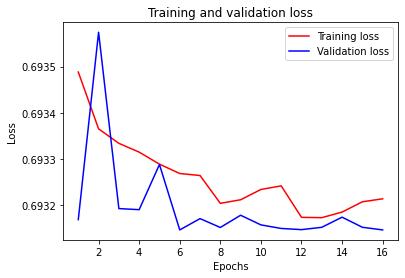

In [78]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

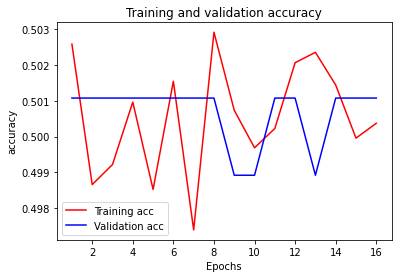

In [79]:
plt.clf() #그림을 초기화

plt.plot(epochs, acc, 'r-', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))

model.add(keras.layers.Dense(128, activation='relu'))

model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.LSTM(128))

model.add(keras.layers.Dense(128, activation='relu'))

model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

-------------------------------------------------------------------------

Epoch 47/100

188/188 [==============================] - 8s 43ms/step - loss: 0.6926 - accuracy: 0.5030 - val_loss: 0.6903 - val_accuracy: 0.5144

Epoch 48/100

188/188 [==============================] - 8s 44ms/step - loss: 0.5426 - accuracy: 0.7074 - val_loss: 0.4163 - val_accuracy: 0.8103

-------------------------------------------------------------------------

results = model.evaluate(x_test, y_test, verbose=2)

1537/1537 - 7s - loss: 0.5436 - accuracy: 0.8256 - 7s/epoch - 5ms/step

-------------------------------------------------------------------------



vocab_size = 10000
word_vector_dim = 200 # 2의 배수

model = keras.Sequential()

model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))

model.add(keras.layers.Dense(128, activation='relu'))

model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.LSTM(128, return_sequences=True))

model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(128, activation='relu'))

model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.LSTM(128))

model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(128, activation='relu'))

model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

--------------------------------------------------------------------

Epoch 100/100

188/188 [==============================] - 15s 80ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5011

--------------------------------------------------------------------

results = model.evaluate(x_test, y_test, verbose=2)

1537/1537 - 12s - loss: 0.6932 - accuracy: 0.4973 - 12s/epoch - 8ms/step

--------------------------------------------------------------------




vocab_size = 10000

word_vector_dim = 200 # 2의 배수


model = keras.Sequential()

model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))

model.add(keras.layers.Dense(128, activation='relu'))

model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.LSTM(128, return_sequences=True))

model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.LSTM(128))

model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(128, activation='relu'))

model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

-----------------------------------------------------------------

Epoch 18: val_loss did not improve from 0.69314
188/188 [==============================] - 14s 75ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.5011

-----------------------------------------------------------------

1537/1537 - 12s - loss: 0.6932 - accuracy: 0.4973 - 12s/epoch - 8ms/step

-----------------------------------------------------------------


vocab_size = 10000

word_vector_dim = 200 # 2의 배수


model = keras.Sequential()

model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))

model.add(keras.layers.LSTM(128, return_sequences=True))

model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.LSTM(128, return_sequences=True))

model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.LSTM(128))

model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

-----------------------------------------------------------------------

Epoch 16: val_loss did not improve from 0.69315

188/188 [==============================] - 20s 106ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.5011

--------------------------------------------------------------------------

1537/1537 - 15s - loss: 0.6932 - accuracy: 0.4973 - 15s/epoch - 10ms/step

--------------------------------------------------------------------------
